## 데이터

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q konlpy

In [209]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import sqlite3
import re

from konlpy.tag import Okt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.linear_model import LinearRegression
import seaborn as sns

# 경고 메시지 표시 X
import warnings
warnings.filterwarnings(action='ignore')

In [210]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib-rf # 세션 다시 시작

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [211]:
# 한글폰트설정
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [212]:
from matplotlib import font_manager as fm
font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

font_prop = fm.FontProperties(fname=font_path)

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

In [213]:
!pip install -q folium

In [214]:
df_info = pd.read_csv('/content/drive/MyDrive/1_public/markets_data/markets_cleaned.csv', encoding='utf-8-sig') # utf-8

In [215]:
df_info.columns # 2024년 데이터

Index(['시장ID', '시장명', '도로명주소', '시도', '시군구', '아케이드 보유 여부', '엘리베이터_에스컬레이터_보유여부',
       '고객지원센터 보유 여부', '시장전용 고객주차장_보유여부', '종합콜센터_보유여부', '스프링쿨러 보유 여부',
       '화재감지기 보유여부', '자동심장충격기_보유여부', '유아놀이방_보유여부', '수유센터_보유여부', '물품보관함_보유여부',
       '자전거보관함_보유여부', '외국인 안내센터_보유여부', '시장유형', '시장개설주기', '점포수', '공중화장실 보유여부',
       '사용가능상품권'],
      dtype='object')

In [216]:
df_info.shape

(1388, 23)

In [217]:
df_info.head()

,시장ID,시장명,도로명주소,시도,시군구,아케이드 보유 여부,엘리베이터_에스컬레이터_보유여부,고객지원센터 보유 여부,시장전용 고객주차장_보유여부,종합콜센터_보유여부,...,유아놀이방_보유여부,수유센터_보유여부,물품보관함_보유여부,자전거보관함_보유여부,외국인 안내센터_보유여부,시장유형,시장개설주기,점포수,공중화장실 보유여부,사용가능상품권
0,경기도 가평군 설악눈메골시장,설악눈메골시장,경기도 가평군 설악면 신천중앙로 104-1,경기도,가평군,N,N,N,Y,N,...,N,N,N,Y,N,NaN,NaN,NaN,NaN,NaN
1,경기도 가평군 가평잣고을시장,가평잣고을시장,경기도 가평군 가평읍 장터2길12 204호,경기도,가평군,Y,N,Y,Y,Y,...,N,N,N,Y,N,NaN,NaN,NaN,NaN,NaN
2,경기도 가평군 청평여울시장,청평여울시장,경기도 가평군 청평면 시장중앙로19,경기도,가평군,Y,Y,N,Y,N,...,N,N,N,Y,N,NaN,NaN,NaN,NaN,NaN
3,경기도 고양시 원당시장,원당시장,경기도 고양시 덕양구 호국로 790번길 17,경기도,고양시,Y,N,Y,Y,Y,...,Y,Y,N,Y,N,상설,상설,70.0,N,온누리상품권
4,경기도 고양시 능곡시장,능곡시장,경기도 고양시 덕양구 능곡로 12의 9,경기도,고양시,N,N,Y,Y,N,...,N,N,N,N,N,상설+정기,5일,120.0,Y,온누리상품권


In [218]:
df_rating = pd.read_csv('/content/drive/MyDrive/1_public/markets_data/markets_rating.csv', encoding='utf-8-sig') # utf-8

In [219]:
df_rating['rating'] = df_rating['rating'].str.split('\n').str[-1]
df_rating.head()

,mID,naverURL,rating
0,경기도 가평군 설악눈메골시장,https://pcmap.place.naver.com/restaurant/14187...,NaN
1,경기도 가평군 가평잣고을시장,https://pcmap.place.naver.com/restaurant/38738...,NaN
2,경기도 가평군 청평여울시장,https://pcmap.place.naver.com/restaurant/11536...,NaN
3,경기도 고양시 원당시장,https://pcmap.place.naver.com/restaurant/32892...,3.77
4,경기도 고양시 능곡시장,https://pcmap.place.naver.com/restaurant/16192...,NaN


In [220]:
df_rating = df_rating.rename(columns={'mID': '시장ID'})

In [221]:
# 병합
df_merge = pd.merge(
    df_info,
    df_rating[['시장ID', 'naverURL', 'rating']],  # 필요한 열만 선택
    how='left',
    on='시장ID',
)

In [222]:
# naverURL 비어있으면 삭제 1388 -> 1296
df_merge = df_merge[df_merge['naverURL'].notna() & (df_merge['naverURL'] != "")]
df_merge.shape

(1296, 25)

In [223]:
# df_merge.to_csv('/content/drive/MyDrive/1_public/markets_data/markets_info_final.csv', encoding='utf-8-sig', index=False)
# df_merge.shape

In [201]:
df_review = pd.read_csv('/content/drive/MyDrive/1_public/markets_data/markets_reviews_final.csv', encoding='utf-8-sig') # utf-8
df_review.shape

(21125, 3)

In [202]:
df_review.columns

Index(['mID', 'rate', 'review'], dtype='object')

---

# 1. 1289개의 시장 리뷰 긍/부정 워드클라우드


In [27]:
df_review.columns

Index(['mID', 'rate', 'review'], dtype='object')

In [28]:
# review 칼럼 Null인 샘플 제거
df_review = df_review[df_review['review'].notnull()]

In [29]:
df_review.shape

(20419, 3)

In [30]:
# 예시: 불용어 처리 등은 나중에 추가
def clean_text(text):
    text = re.sub(r'[^가-힣\s]', '', str(text))  # 한글과 공백만 남김
    text = re.sub(r'\s+', ' ', text).strip()     # 공백 정리
    return text

df_review['clean_review'] = df_review['review'].apply(clean_text)

In [31]:
# 감정 사전
positive_words = [
    '맛있', '친절', '깔끔', '좋', '편하', '재밌', '행복', '친근', '만족', '추천', '훌륭', '깨끗',
    '신선', '완벽', '최고', '감동', '놀라운', '탁월', '우수', '뛰어난', '환상적', '멋진'
]

negative_words = [
    '불친절', '더럽', '시끄럽', '짜증', '별로', '불편', '비싸', '불만', '나쁘', '힘들', '지루',
    '실망', '최악', '끔찍', '형편없', '화나', '답답', '짜증나', '귀찮', '스트레스'
]

def get_sentiment(text):
    pos_score = sum(word in text for word in positive_words)
    neg_score = sum(word in text for word in negative_words)
    if pos_score > neg_score:
        return 'positive'
    elif pos_score < neg_score:
        return 'negative'
    else:
        return 'neutral'

df_review['sentiment'] = df_review['clean_review'].apply(get_sentiment)

(np.float64(-0.5), np.float64(799.5), np.float64(399.5), np.float64(-0.5))

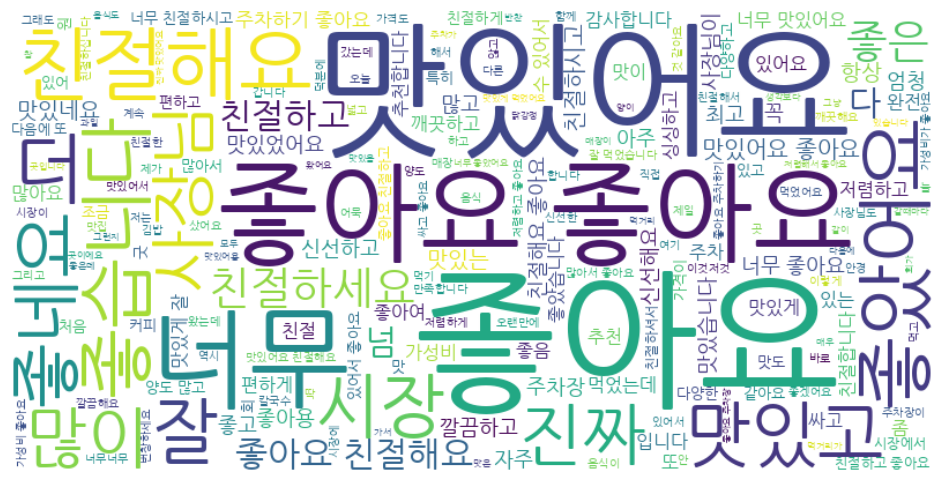

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 긍정 리뷰 모아 워드클라우드
pos_text = ' '.join(df_review[df_review['sentiment'] == 'positive']['clean_review'])
neg_text = ' '.join(df_review[df_review['sentiment'] == 'negative']['clean_review'])

wordcloud_pos = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
                          background_color='white', width=800, height=400,
                          stopwords={'좋아', '정말'}).generate(pos_text)

wordcloud_neg = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
                          background_color='white', colormap='Reds', width=800, height=400,
                          stopwords={'와서먹다가'}).generate(neg_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')

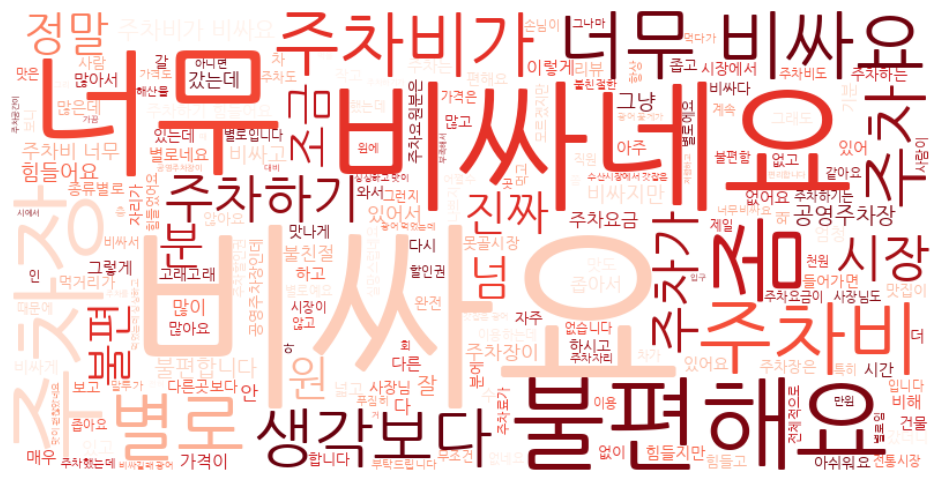

In [17]:
plt.figure(figsize=(12,6))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.show()

# 2. 수도권/지방 시장 리뷰 긍/부정 워드클라우드
> - 경기도, 서울, 인천
> - 나머지 지방
> - TF-IDF 상위단어만 추출해서 비교
> - 수도권 워드클라우드에 있는 단어는 수도권에서 상대적으로 더 중요하게 언급된 단어
> - 지방 워드클라우드는 지방 시장에서의 특징적인 단어를 보여줌
> - 공통 단어는 자동으로 제외되거나 중요도가 낮게 처리됨

## TF-IDF
> - 리뷰를 형태소 분석 후 문서화
> - TF-IDF 계산
> - 워드클라우드 생성

## 공통점과 차이점
| 구분      | 해석                                       |
| ------- | ---------------------------------------- |
| **수도권** | 생활밀착형 시장, 주기적 방문, 가격·주차 외에 친근감/만족도 중심 리뷰 |
| **지방**  | 관광지형 시장, 교통과 관련된 언급, 구경거리·거리감에 대한 언급     |

✨ 수도권 특이 단어

자주:
→ 수도권 시장은 생활권에 가까워 반복 방문한다는 인상을 줌
→ 예: "집 앞이라 자주 가요", "주말마다 자주 들러요"

진짜:
→ 감탄사, 강조 표현으로 친숙함이나 만족도를 표현
→ 예: "진짜 싸요", "진짜 친절함"

🧳 지방 특이 단어

구경:
→ 관광 목적의 시장 방문. 여행객 중심 리뷰
→ 예: "구경할 것도 많고 재밌어요", "볼거리 많아서 좋았어요"

차비:
→ 시장 접근성 언급. 교통비 부담, 거리 문제
→ 예: "차비 들여 일부러 왔는데...", "차비 아까운 시장은 아니었어요"




In [33]:
df_info['시도'].unique()

array(['경기도', '수원시', '서울특별시', '중구', '인천광역시', '대전광역시', '세종특별자치시', '충청남도',
       '충청북도', '광주광역시', '전라남도', '전라북도', '경상북도', '대구광역시', '경상남도', '부산광역시',
       '울산광역시', '강원도', '제주특별자치도'], dtype=object)

In [34]:
# 수도권 시도 목록
capital_region = ['서울특별시', '경기도', '인천광역시']

# 수도권 여부 컬럼 추가
df_merged = pd.merge(df_info, df_review, left_on='시장ID', right_on='mID', how='inner')
df_merged['수도권'] = df_merged['시도'].apply(lambda x: '수도권' if x in capital_region else '지방')

In [35]:
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer

okt = Okt()

# 텍스트 정제 함수
def tokenize(text):
    nouns = okt.nouns(text)
    return [word for word in nouns if len(word) > 1]

# 수도권/지방 문서 생성
capital_reviews = " ".join(df_merged[df_merged['수도권'] == '수도권']['review'].dropna())
local_reviews = " ".join(df_merged[df_merged['수도권'] == '지방']['review'].dropna())

docs = [capital_reviews, local_reviews]

In [36]:
# 직접 tokenizer 함수 지정 (Okt 사용)
vectorizer = TfidfVectorizer(tokenizer=tokenize, max_features=300)
tfidf_matrix = vectorizer.fit_transform(docs)

# 단어와 점수 추출
words = vectorizer.get_feature_names_out()
capital_scores = tfidf_matrix[0].toarray().flatten()
local_scores = tfidf_matrix[1].toarray().flatten()

# 딕셔너리 형태로 저장
capital_dict = {word: score for word, score in zip(words, capital_scores)}
local_dict = {word: score for word, score in zip(words, local_scores)}

(np.float64(-0.5), np.float64(799.5), np.float64(399.5), np.float64(-0.5))

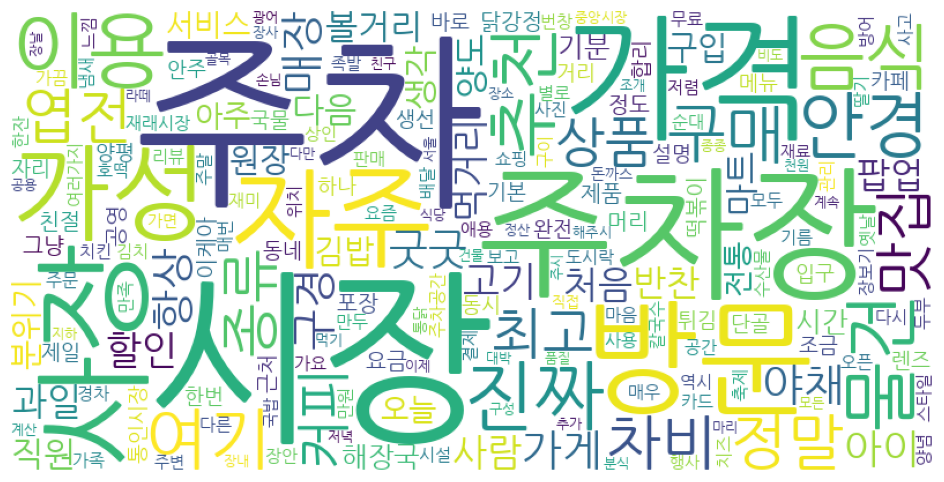

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud_capital = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf', width=800, height=400, background_color='white')
wordcloud_local = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf', width=800, height=400, background_color='white')

# 워드클라우드 표시
plt.figure(figsize=(14,6))
plt.imshow(wordcloud_capital.generate_from_frequencies(capital_dict))
plt.axis('off')

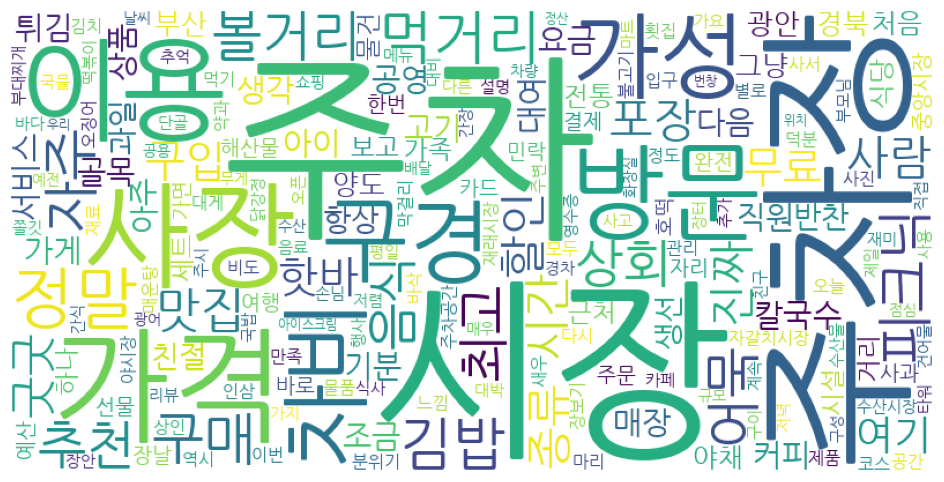

In [39]:
plt.figure(figsize=(14,6))
plt.imshow(wordcloud_local.generate_from_frequencies(local_dict))
plt.axis('off')
plt.show()

In [40]:
# 단어 빈도 계산

# 수도권 리뷰
capital_text = " ".join(df_merged[df_merged['수도권'] == '수도권']['review'].dropna())
capital_nouns = okt.nouns(capital_text)
capital_filtered = [word for word in capital_nouns if len(word) > 1]

# 지방 리뷰
local_text = " ".join(df_merged[df_merged['수도권'] == '지방']['review'].dropna())
local_nouns = okt.nouns(local_text)
local_filtered = [word for word in local_nouns if len(word) > 1]

capital_counts = Counter(capital_filtered)
local_counts = Counter(local_filtered)

# 상위 10개 단어 비교
print("✅ 수도권 TOP10:", capital_counts.most_common(10))
print("✅ 지방 TOP10:", local_counts.most_common(10))

✅ 수도권 TOP10: [('시장', 702), ('주차', 698), ('주차장', 369), ('가격', 326), ('방문', 267), ('사장', 253), ('자주', 203), ('가성', 191), ('이용', 184), ('진짜', 151)]
✅ 지방 TOP10: [('주차', 1151), ('시장', 1084), ('주차장', 730), ('가격', 381), ('사장', 320), ('이용', 309), ('방문', 257), ('가성', 208), ('구경', 198), ('차비', 196)]


In [42]:
# # 수도권/지방 상위 10개 단어 가져오기
# top_capital = capital_counts.most_common(10)
# top_local = local_counts.most_common(10)

# # DataFrame으로 변환
# df_capital = pd.DataFrame(top_capital, columns=['단어', '수도권 빈도'])
# df_local = pd.DataFrame(top_local, columns=['단어', '지방 빈도'])

# # 단어 기준으로 병합
# df_compare = pd.merge(df_capital, df_local, on='단어', how='outer').fillna(0)

# # 시각화
# df_compare.set_index('단어').plot(kind='bar', figsize=(12, 6))
# plt.title('수도권 vs 지방 리뷰 단어 빈도 TOP10')
# plt.xlabel('단어')
# plt.ylabel('빈도 수')
# plt.xticks(rotation=45)
# plt.legend()
# plt.tight_layout()
# plt.show()

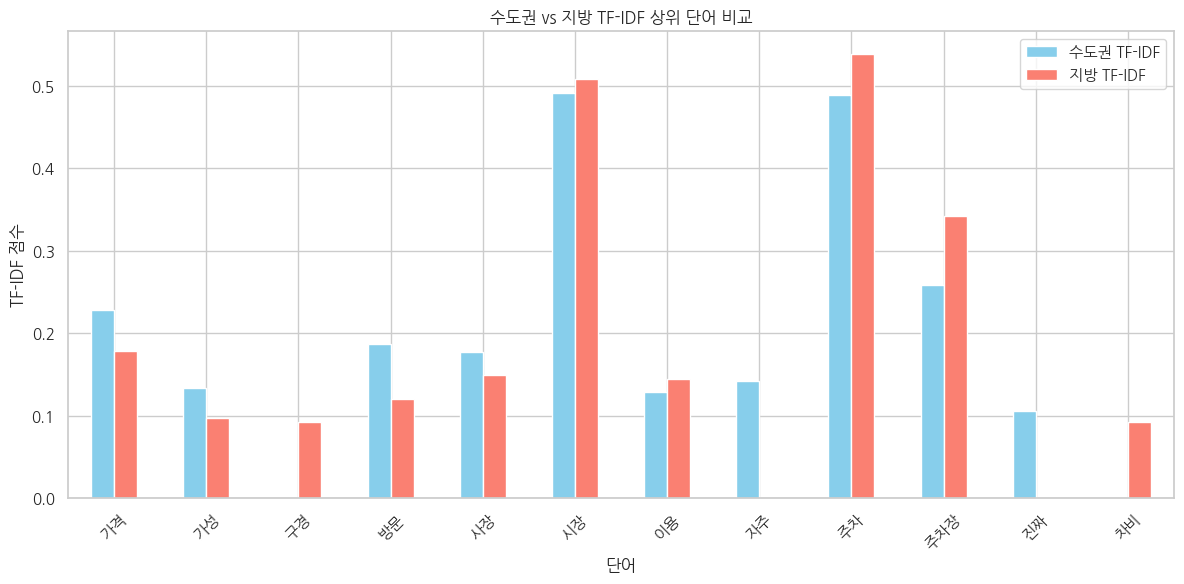

In [46]:
# 수도권/지방 상위 10개 단어 가져오기 (TF-IDF 기준)
top_capital = sorted(capital_dict.items(), key=lambda x: x[1], reverse=True)[:10]
top_local = sorted(local_dict.items(), key=lambda x: x[1], reverse=True)[:10]

# DataFrame으로 변환
df_capital = pd.DataFrame(top_capital, columns=['단어', '수도권 TF-IDF'])
df_local = pd.DataFrame(top_local, columns=['단어', '지방 TF-IDF'])

# 단어 기준으로 병합
df_compare = pd.merge(df_capital, df_local, on='단어', how='outer').fillna(0)

# 시각화
df_compare.set_index('단어').plot(kind='bar', figsize=(12, 6), color=['skyblue', 'salmon'])
plt.title('수도권 vs 지방 TF-IDF 상위 단어 비교')
plt.xlabel('단어')
plt.ylabel('TF-IDF 점수')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 3. 시설 유무별 만족도 차이 분석
> - 예: 엘리베이터 보유 시장 vs 미보유 시장 간 평균 평점 차이
> - 예: 주차장 보유 시장 vs 미보유 시장 간 평균 평점 차이
> - 예: 공중화장실 보유 시장 vs 미보유 시장 간 평균 평점 차이
> - 예: 고객지원센터 보유 시장 vs 미보유 시장 간 평균 평점 차이
> - 예: 아케이드 vs 미보유 시장 간 평균 평점 차이

- 분석 목적: 어떤 시설이 실제로 리뷰 평점에 긍정적 영향을 미치는지 확인
- 예: 주차장 보유 vs 미보유, 아케이드 보유 vs 미보유.
- 두 집단(또는 다중 집단)의 평균 평점 차이가 통계적으로 유의한지 검정 → “투자 우선순위” 근거 마련.

> - ✅ 용어 정리: 유의미한 관계란?
→ **“시설 보유 여부에 따라 시장의 평균 평점이 통계적으로 유의하게 다르다”**는 뜻입니다.
> - 귀무가설 (H₀):
→ 자전거보관함(또는 유아놀이방) 보유 여부에 따라 평점에 차이가 없다.
> - 대립가설 (H₁):
→ 보유 여부에 따라 평점에 차이가 있다.




In [123]:
df_info.columns

Index(['시장ID', '시장명', '도로명주소', '시도', '시군구', '아케이드 보유 여부', '엘리베이터_에스컬레이터_보유여부',
       '고객지원센터 보유 여부', '시장전용 고객주차장_보유여부', '종합콜센터_보유여부', '스프링쿨러 보유 여부',
       '화재감지기 보유여부', '자동심장충격기_보유여부', '유아놀이방_보유여부', '수유센터_보유여부', '물품보관함_보유여부',
       '자전거보관함_보유여부', '외국인 안내센터_보유여부', '시장유형', '시장개설주기', '점포수', '공중화장실 보유여부',
       '사용가능상품권'],
      dtype='object')

In [124]:
df_rating.columns

Index(['시장ID', 'naverURL', 'rating'], dtype='object')

🔍 시설명: 엘리베이터_에스컬레이터_보유여부
   엘리베이터_에스컬레이터_보유여부  count      mean
0                  0    302  4.320199
1                  1    105  4.281429 



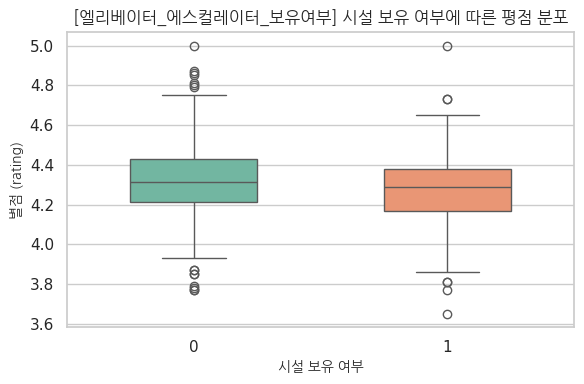

🔍 시설명: 시장전용 고객주차장_보유여부
   시장전용 고객주차장_보유여부  count      mean
0                0     53  4.325094
1                1    354  4.307966 



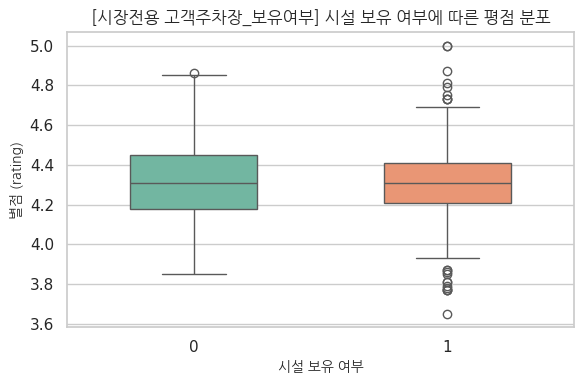

🔍 시설명: 공중화장실 보유여부
   공중화장실 보유여부  count      mean
0         0.0     27  4.345185
1         1.0    304  4.315625 



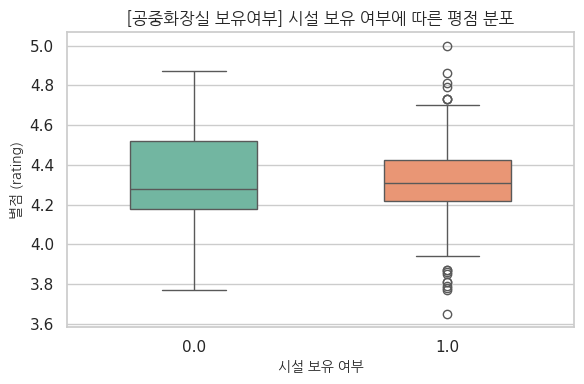

🔍 시설명: 고객지원센터 보유 여부
   고객지원센터 보유 여부  count      mean
0             0     44  4.350455
1             1    363  4.305317 



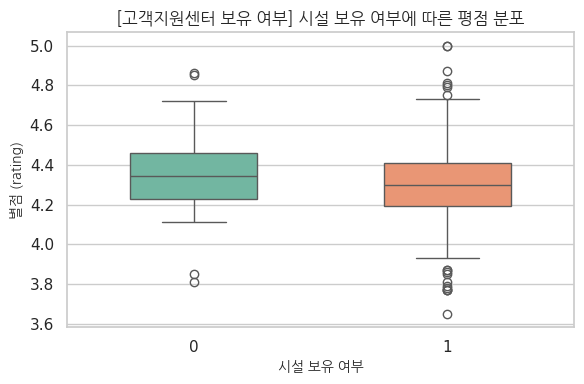

🔍 시설명: 아케이드 보유 여부
   아케이드 보유 여부  count      mean
0           0     98  4.344184
1           1    309  4.299417 



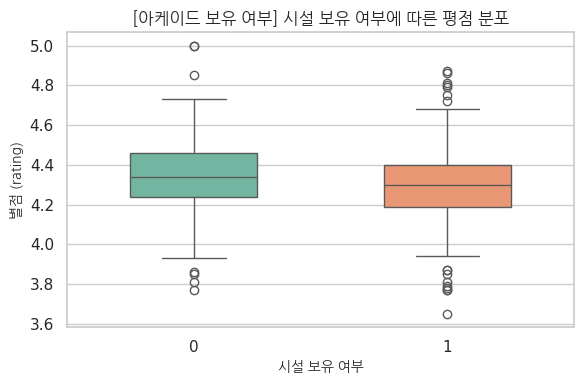

🔍 시설명: 자전거보관함_보유여부
   자전거보관함_보유여부  count      mean
0            0    208  4.329904
1            1    199  4.289598 



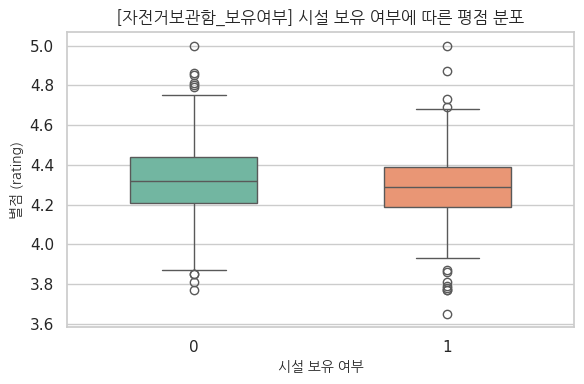

🔍 시설명: 외국인 안내센터_보유여부
   외국인 안내센터_보유여부  count      mean
0              0    359  4.312033
1              1     48  4.296458 



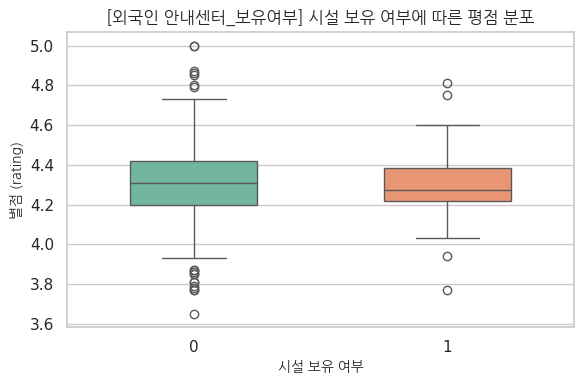

🔍 시설명: 유아놀이방_보유여부
   유아놀이방_보유여부  count      mean
0           0    299  4.322943
1           1    108  4.274907 



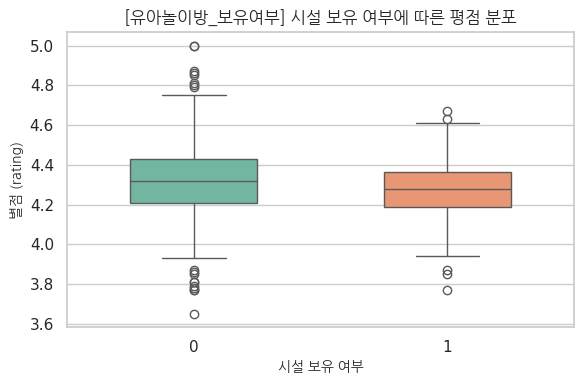

🔍 시설명: 수유센터_보유여부
   수유센터_보유여부  count      mean
0          0    284  4.318239
1          1    123  4.291626 



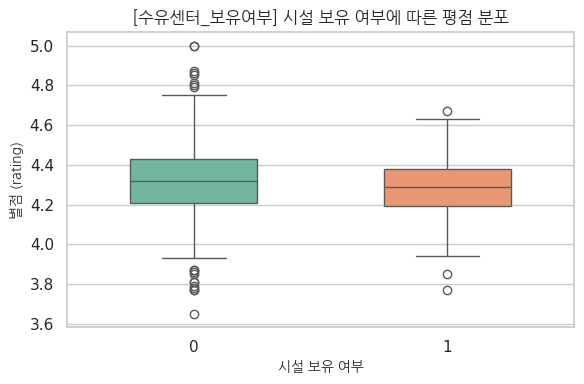

🔍 시설명: 물품보관함_보유여부
   물품보관함_보유여부  count      mean
0           0    276  4.314601
1           1    131  4.300916 



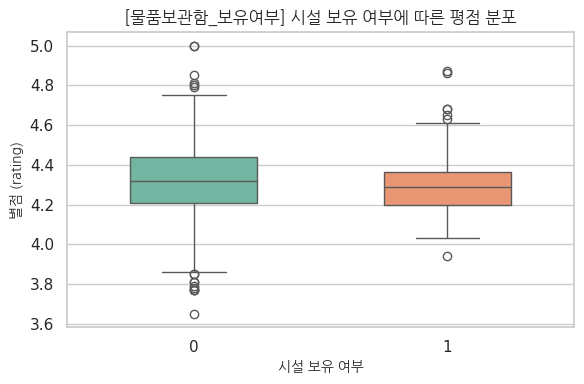

🔍 시설명: 종합콜센터_보유여부
   종합콜센터_보유여부  count      mean
0           0    195  4.325949
1           1    212  4.295708 



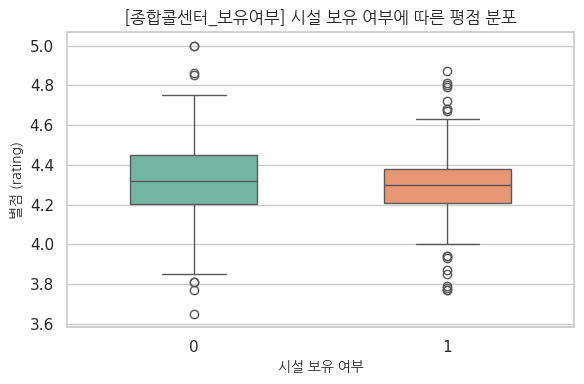

🔍 시설명: 스프링쿨러 보유 여부
   스프링쿨러 보유 여부  count      mean
0            0    142  4.300915
1            1    265  4.315170 



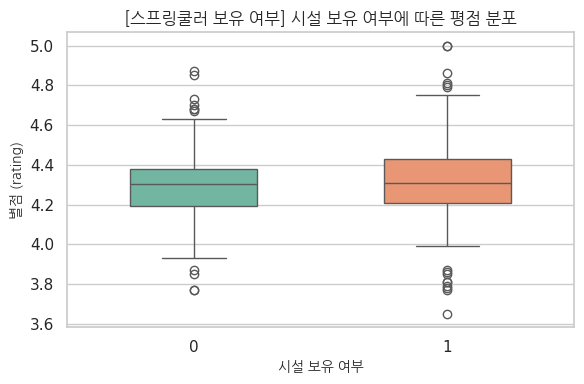

🔍 시설명: 화재감지기 보유여부
   화재감지기 보유여부  count      mean
0           0     31  4.283871
1           1    376  4.312367 



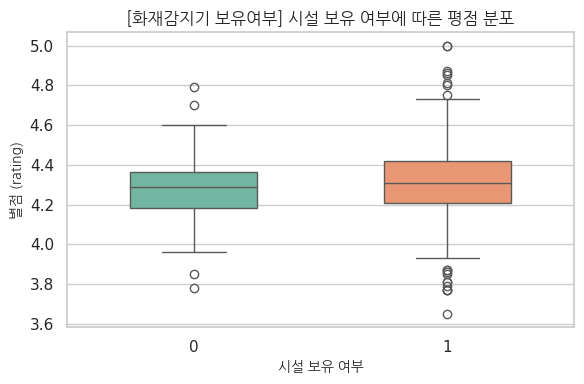

🔍 시설명: 자동심장충격기_보유여부
   자동심장충격기_보유여부  count      mean
0             0    191  4.324764
1             1    216  4.297315 



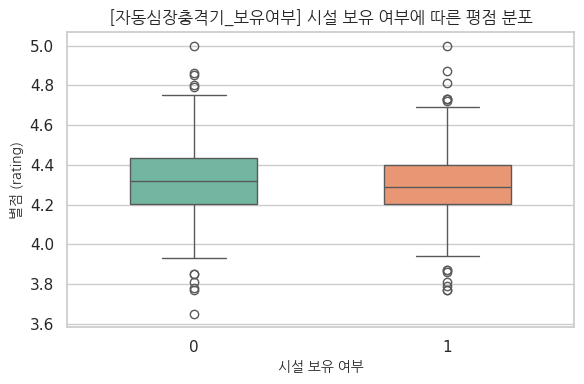

In [125]:
# 평균 평점이 높은게 화재감지기랑 스프링쿨러
# 컬럼 정리 및 병합
df_rating = df_rating[['시장ID', 'naverURL', 'rating']].copy()
df_rating['rating'] = pd.to_numeric(df_rating['rating'], errors='coerce')  # rating이 문자열이면 수치로 변환

# '시장ID'와 'mID' 기준으로 병합
df_merged = pd.merge(df_info, df_rating, on='시장ID', how='inner')

# 분석할 주요 시설 컬럼들 (표현 일관성 위해 컬럼명을 리스트로 수동 작성)
facility_cols = [
    '엘리베이터_에스컬레이터_보유여부',
    '시장전용 고객주차장_보유여부',
    '공중화장실 보유여부',
    '고객지원센터 보유 여부',
    '아케이드 보유 여부',
    '자전거보관함_보유여부',
    '외국인 안내센터_보유여부',
    '유아놀이방_보유여부',
    '수유센터_보유여부',
    '물품보관함_보유여부',
    '종합콜센터_보유여부',
    '스프링쿨러 보유 여부',
    '화재감지기 보유여부',
    '자동심장충격기_보유여부',
]

for col in facility_cols:
    print(f"🔍 시설명: {col}")

    group_stats = df_merged.groupby(col)['rating'].agg(['count', 'mean']).reset_index()
    print(group_stats, '\n')

    plt.figure(figsize=(6, 4))
    sns.set(style="whitegrid")

    ax = sns.boxplot(
        data=df_merged,
        x=col,
        y='rating',
        palette='Set2',
        width=0.5
    )
    ax.set_title(f"[{col}] 시설 보유 여부에 따른 평점 분포", fontsize=12, fontproperties=font_prop)
    ax.set_xlabel("시설 보유 여부", fontsize=10, fontproperties=font_prop)
    ax.set_ylabel("별점 (rating)", fontsize=10, fontproperties=font_prop)

    plt.tight_layout()
    plt.show()

In [79]:
from scipy.stats import ttest_ind

for col in facility_cols:
    # 0 = 미보유, 1 = 보유 (또는 'N', 'Y'인 경우도 처리 가능)
    group1 = df_merged[df_merged[col] == 'Y']['rating'].dropna()
    group2 = df_merged[df_merged[col] == 'N']['rating'].dropna()

    # 조건 확인 후 t-test 실행
    if len(group1) > 10 and len(group2) > 10:
        t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
        print(f"# {col} → p-value: {p_val:.4f}")
        if p_val < 0.05:
            print("   -> 시설 보유 여부에 따라 유의한 평점 차이 있음\n")
        else:
            print("   -> 유의한 차이 없음\n")

# 엘리베이터_에스컬레이터_보유여부 → p-value: 0.0836
   -> 유의한 차이 없음

# 시장전용 고객주차장_보유여부 → p-value: 0.5904
   -> 유의한 차이 없음

# 공중화장실 보유여부 → p-value: 0.5642
   -> 유의한 차이 없음

# 고객지원센터 보유 여부 → p-value: 0.1778
   -> 유의한 차이 없음

# 아케이드 보유 여부 → p-value: 0.0723
   -> 유의한 차이 없음

# 자전거보관함_보유여부 → p-value: 0.0365
   -> 시설 보유 여부에 따라 유의한 평점 차이 있음

# 외국인 안내센터_보유여부 → p-value: 0.5809
   -> 유의한 차이 없음

# 유아놀이방_보유여부 → p-value: 0.0130
   -> 시설 보유 여부에 따라 유의한 평점 차이 있음

# 수유센터_보유여부 → p-value: 0.1535
   -> 유의한 차이 없음

# 물품보관함_보유여부 → p-value: 0.4574
   -> 유의한 차이 없음

# 종합콜센터_보유여부 → p-value: 0.1202
   -> 유의한 차이 없음

# 스프링쿨러 보유 여부 → p-value: 0.4745
   -> 유의한 차이 없음

# 화재감지기 보유여부 → p-value: 0.4983
   -> 유의한 차이 없음

# 자동심장충격기_보유여부 → p-value: 0.1581
   -> 유의한 차이 없음



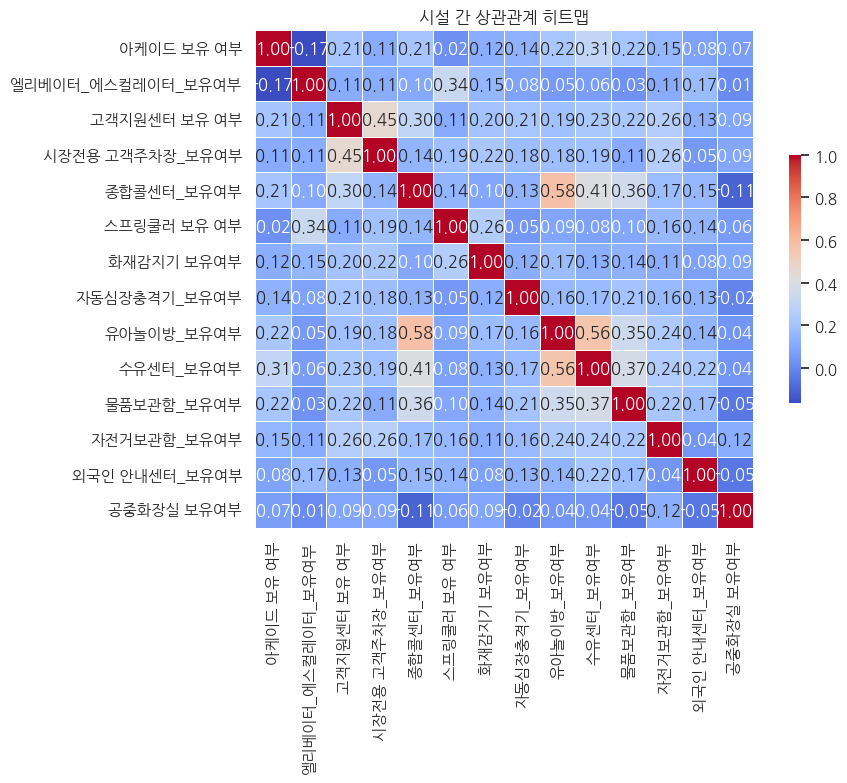

In [243]:
# Y/N을 1/0으로 변환하여 상관계수 계산에 사용
df_binary = df_merged[facility_cols].replace({'Y': 1, 'N': 0})

corr_matrix = df_binary.corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.set(style="white")

# 한글 폰트 등록
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

# 히트맵 생성
sns.heatmap(
    corr_matrix,
    annot=True,        # 숫자 표시
    fmt=".2f",         # 소수점 2자리
    cmap='coolwarm',   # 색상 맵
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5},
)

plt.title("시설 간 상관관계 히트맵", fontsize=14, fontproperties=font_prop)
plt.tight_layout()
plt.show()

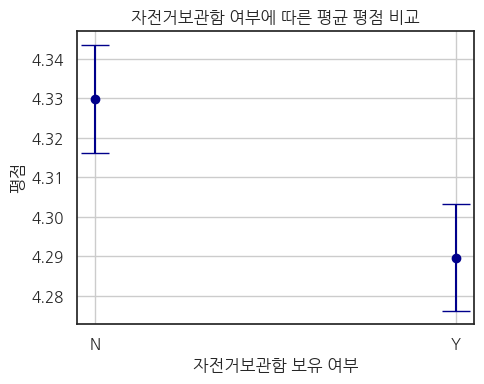

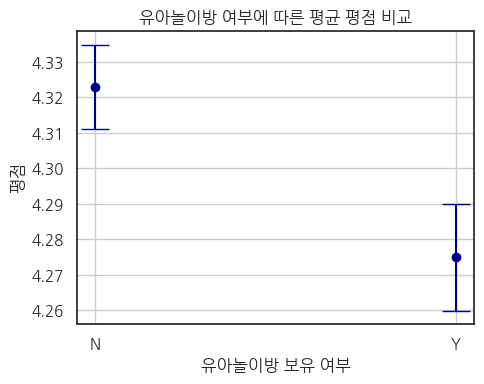

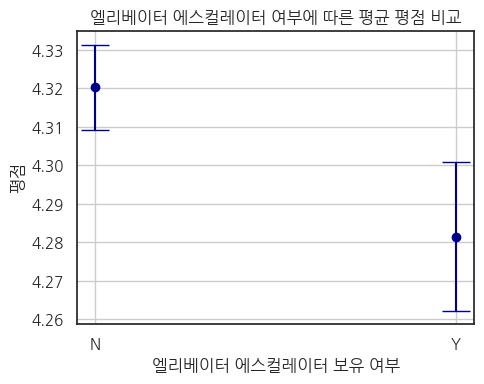

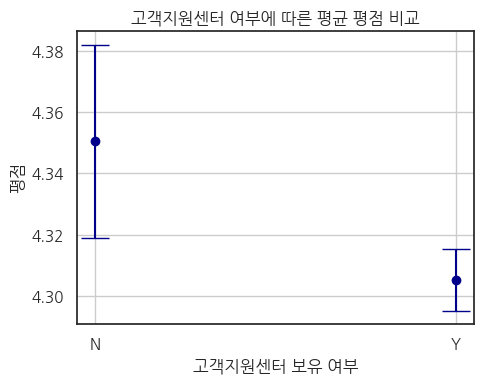

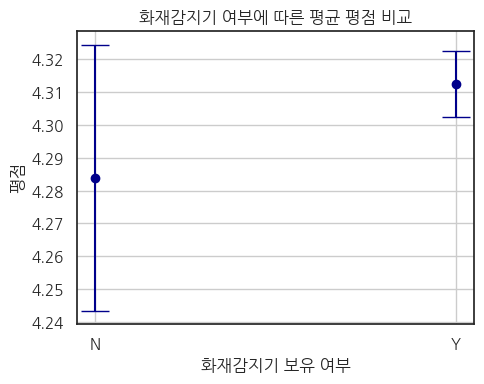

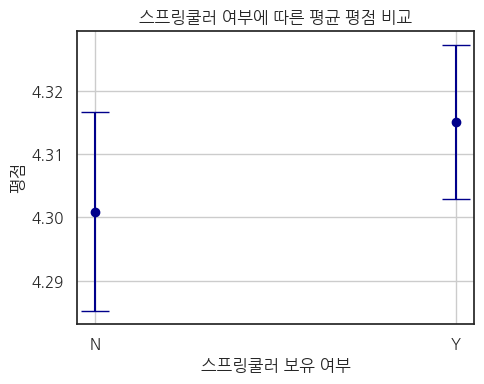

In [112]:
import matplotlib.pyplot as plt
# '시장ID'와 'mID' 기준으로 병합
df_merged = pd.merge(df_info, df_rating, on='시장ID', how='inner')

df_plot = df_merged.copy()

# 필요한 범주형 변수 → 숫자형 변수로도 만들어두면 나중에 시각화나 회귀에도 활용 가능
df_plot['자전거보관함_보유여부_num'] = df_plot['자전거보관함_보유여부'].map({'Y': 1, 'N': 0})
df_plot['유아놀이방_보유여부_num'] = df_plot['유아놀이방_보유여부'].map({'Y': 1, 'N': 0})
df_plot['엘리베이터_에스컬레이터_보유여부_num'] = df_plot['엘리베이터_에스컬레이터_보유여부'].map({'Y': 1, 'N': 0})
df_plot['고객지원센터 보유 여부_num'] = df_plot['고객지원센터 보유 여부'].map({'Y': 1, 'N': 0})
df_plot['화재감지기 보유여부_num'] = df_plot['화재감지기 보유여부'].map({'Y': 1, 'N': 0})
df_plot['스프링쿨러 보유 여부_num'] = df_plot['스프링쿨러 보유 여부'].map({'Y': 1, 'N': 0})


# 평균과 표준오차 계산
def plot_mean_ci(col, title):
    group_mean = df_plot.groupby(col)['rating'].mean()
    group_sem = df_plot.groupby(col)['rating'].sem()  # 표준 오차

    plt.figure(figsize=(5, 4))
    plt.errorbar(
        x=group_mean.index,
        y=group_mean.values,
        yerr=group_sem.values,
        fmt='o', capsize=10, color='darkblue'
    )

    plt.title(f"{title} 여부에 따른 평균 평점 비교", fontproperties=font_prop)
    plt.xlabel(f"{title} 보유 여부", fontproperties=font_prop)
    plt.ylabel("평점", fontproperties=font_prop)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 실행
plot_mean_ci('자전거보관함_보유여부', '자전거보관함')
plot_mean_ci('유아놀이방_보유여부', '유아놀이방')
plot_mean_ci('엘리베이터_에스컬레이터_보유여부', '엘리베이터 에스컬레이터')
plot_mean_ci('고객지원센터 보유 여부', '고객지원센터')
plot_mean_ci('화재감지기 보유여부', '화재감지기')
plot_mean_ci('스프링쿨러 보유 여부', '스프링쿨러')

In [111]:
print("✅ 자전거보관함 보유 여부별 평균 평점")
print(df_plot.groupby('자전거보관함_보유여부')['rating'].agg(['mean', 'std', 'count']))

print("\n✅ 유아놀이방 보유 여부별 평균 평점")
print(df_plot.groupby('유아놀이방_보유여부')['rating'].agg(['mean', 'std', 'count']))

print("\n✅ 화재감지기 보유 여부별 평균 평점")
print(df_plot.groupby('화재감지기 보유여부')['rating'].agg(['mean', 'std', 'count']))

print("\n✅ 스프링쿨러 보유 여부별 평균 평점")
print(df_plot.groupby('스프링쿨러 보유 여부')['rating'].agg(['mean', 'std', 'count']))

✅ 자전거보관함 보유 여부별 평균 평점
                 mean       std  count
자전거보관함_보유여부                           
N            4.329904  0.197134    208
Y            4.289598  0.190408    199

✅ 유아놀이방 보유 여부별 평균 평점
                mean       std  count
유아놀이방_보유여부                           
N           4.322943  0.205431    299
Y           4.274907  0.156745    108

✅ 화재감지기 보유 여부별 평균 평점
                mean       std  count
화재감지기 보유여부                           
N           4.283871  0.225088     31
Y           4.312367  0.192146    376

✅ 스프링쿨러 보유 여부별 평균 평점
                 mean       std  count
스프링쿨러 보유 여부                           
N            4.300915  0.187435    142
Y            4.315170  0.198630    265


In [113]:
print(df_plot[['rating', '화재감지기 보유여부_num']].corr())
print(df_plot[['rating', '스프링쿨러 보유 여부_num']].corr())

                  rating  화재감지기 보유여부_num
rating          1.000000        0.038875
화재감지기 보유여부_num  0.038875        1.000000
                  rating  스프링쿨러 보유 여부_num
rating           1.00000          0.03494
스프링쿨러 보유 여부_num  0.03494          1.00000


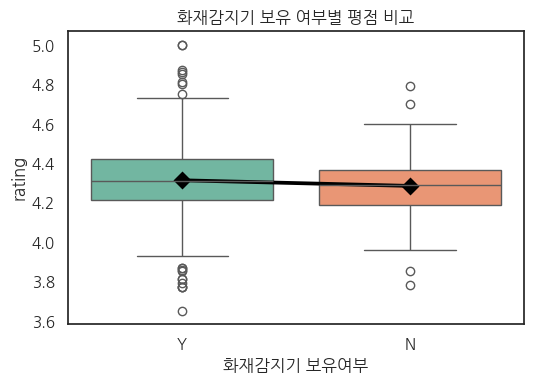

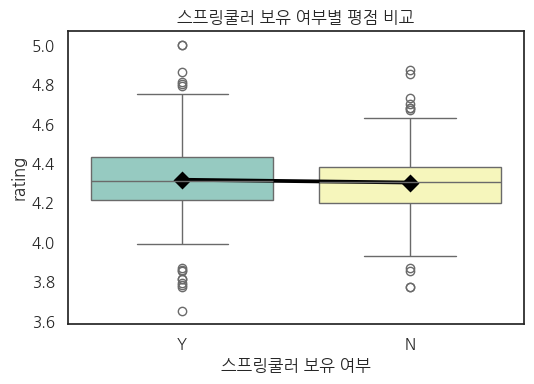

In [117]:
# 화재감지기
plt.figure(figsize=(5.5, 4))
sns.boxplot(data=df_plot, x='화재감지기 보유여부', y='rating', palette='Set2')
sns.pointplot(data=df_plot, x='화재감지기 보유여부', y='rating', color='black', ci=None, markers='D')
plt.title("화재감지기 보유 여부별 평점 비교", fontproperties=font_prop)
plt.tight_layout()
plt.show()

# 스프링쿨러
plt.figure(figsize=(5.5, 4))
sns.boxplot(data=df_plot, x='스프링쿨러 보유 여부', y='rating', palette='Set3')
sns.pointplot(data=df_plot, x='스프링쿨러 보유 여부', y='rating', color='black', ci=None, markers='D')
plt.title("스프링쿨러 보유 여부별 평점 비교", fontproperties=font_prop)
plt.tight_layout()
plt.show()

In [118]:
df_merged['화재감지기 보유여부'].value_counts()

,count
화재감지기 보유여부,
Y,1093
N,203


> - 화재감지기 및 스프링쿨러의 보유 여부에 따라, 보유 시장이 평균적으로 다소 높은 평점을 보이는 경향이 나타났으나,
두 집단 모두 표준편차가 크고 집단 간 차이의 효과 크기가 작아,
통계적으로 유의한 차이(p = 0.4983, p = 0.4745)는 확인되지 않았다.
이는 화재감지기와 스프링쿨러의 보유가 소비자 만족도(평점)에 미치는 직접적 영향이 제한적일 수 있음을 시사한다.
> - 자전거보관함 보유 여부에 따라 평점 평균의 차이는 통계적으로 유의하였으며(p = 0.0365),
오히려 보유 시장에서 평균 평점이 낮은 경향을 보였다.
이는 자전거보관함 자체가 만족도를 끌어올리는 요소라기보다는,
접근성이 떨어지는 대형시장, 비도심 시장 등에 설치된 경우가 많을 수 있음을 시사한다.
> - 유아놀이방 보유 시장은 오히려 평균 평점이 낮았으며, 이 차이는 통계적으로도 유의하였다(p = 0.013).
이는 유아놀이방이 설치된 시장이 규모가 크거나, 기타 서비스 품질이 낮은 시장과 동반되어 있는 경우일 수 있으며,
단일 시설만으로는 소비자 만족도에 긍정적 영향을 주지 못할 수 있음을 의미한다.
> - 한편, 유아놀이방과 자전거보관함은 각각 p = 0.013, 0.0365로 통계적으로 유의한 평점 차이를 나타냈다.
그러나 시각화 결과, 두 시설 모두 보유 그룹에서 평균 평점이 낮은 경향을 보여,
단일 시설 보유 자체가 만족도를 끌어올린다기보다, 해당 시설이 설치된 시장의 전반적인 특성과
관련된 결과일 가능성이 있다.
이는 시설 보유 여부를 단독 변수로 보기보다는, 시장 전반의 복합적 조건을 함께 고려한 분석이 필요함을 시사한다.



# 4. 리뷰 수 자체와 시설 수의 관계
> - 시설 수가 많을수록 리뷰 수가 많은가?
> - 회귀 분석을 통해 어떤 시설이 리뷰 수에 영향을 미치는지 확인

> - 회귀계수가 클수록 해당 시설을 가진 시장일수록 리뷰 수가 많다는 의미
> - R² 값이 높을수록 시설만으로 리뷰 수를 잘 설명함
> - 이 결과를 통해 투자 우선순위 또는 시설 개선 전략 수립 가능



In [156]:
# '시장ID'와 'mID' 기준으로 병합
df_merged = pd.merge(df_info, df_rating, on='시장ID', how='inner')

In [157]:
print(df_merged[facility_cols].isna().sum())

아케이드 보유 여부             0
엘리베이터_에스컬레이터_보유여부      0
고객지원센터 보유 여부           0
시장전용 고객주차장_보유여부        0
종합콜센터_보유여부             0
스프링쿨러 보유 여부            0
화재감지기 보유여부             0
자동심장충격기_보유여부           0
유아놀이방_보유여부             0
수유센터_보유여부              0
물품보관함_보유여부             0
자전거보관함_보유여부            0
외국인 안내센터_보유여부          0
공중화장실 보유여부           244
dtype: int64


In [158]:
df_merged['공중화장실 보유여부'] = df_merged['공중화장실 보유여부'].fillna(0) # 공중화장실 0으로

In [159]:
print(df_merged[facility_cols].isna().sum())

아케이드 보유 여부           0
엘리베이터_에스컬레이터_보유여부    0
고객지원센터 보유 여부         0
시장전용 고객주차장_보유여부      0
종합콜센터_보유여부           0
스프링쿨러 보유 여부          0
화재감지기 보유여부           0
자동심장충격기_보유여부         0
유아놀이방_보유여부           0
수유센터_보유여부            0
물품보관함_보유여부           0
자전거보관함_보유여부          0
외국인 안내센터_보유여부        0
공중화장실 보유여부           0
dtype: int64


회귀계수 (시설별 영향력):
 수유센터_보유여부            6.862647
자동심장충격기_보유여부         5.910351
종합콜센터_보유여부           5.707424
유아놀이방_보유여부           5.520948
엘리베이터_에스컬레이터_보유여부    4.277293
자전거보관함_보유여부          3.567846
아케이드 보유 여부           3.203005
물품보관함_보유여부           2.609086
스프링쿨러 보유 여부          1.380597
화재감지기 보유여부           1.337540
공중화장실 보유여부           0.991680
고객지원센터 보유 여부         0.824913
외국인 안내센터_보유여부       -0.493259
시장전용 고객주차장_보유여부     -2.464408
dtype: float64
절편: 4.4786505137039025
R² (설명력): 0.10152824413064432


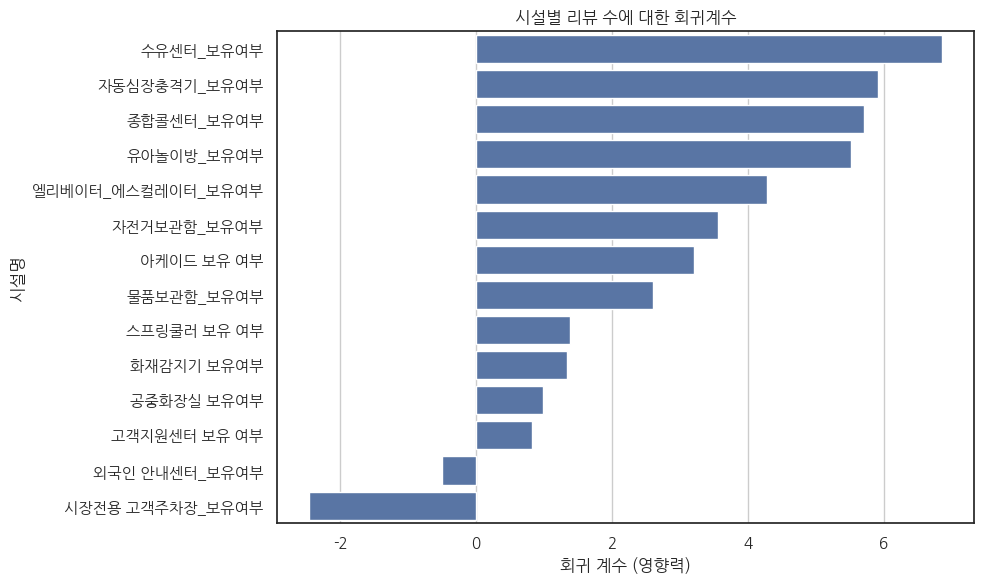

In [182]:
# 시설 여부를 0/1로 변환
facility_cols = [
    '아케이드 보유 여부', '엘리베이터_에스컬레이터_보유여부', '고객지원센터 보유 여부', '시장전용 고객주차장_보유여부',
    '종합콜센터_보유여부', '스프링쿨러 보유 여부', '화재감지기 보유여부', '자동심장충격기_보유여부',
    '유아놀이방_보유여부', '수유센터_보유여부', '물품보관함_보유여부', '자전거보관함_보유여부',
    '외국인 안내센터_보유여부', '공중화장실 보유여부'
]

for col in facility_cols:
    df_info[col] = df_info[col].map({'Y': 1, 'N': 0})

# 시장별 리뷰 수 계산
review_counts = df_review.groupby('mID').size().reset_index(name='리뷰수')

# 병합
df_merged = pd.merge(df_info, review_counts, left_on='시장ID', right_on='mID', how='inner')

# NaN 처리 공중화장실
df_merged['공중화장실 보유여부'] = df_merged['공중화장실 보유여부'].fillna(0)

# 회귀 분석
X = df_merged[facility_cols]  # 독립 변수: 시설 보유 여부
y = df_merged['리뷰수']       # 종속 변수: 리뷰 수

model = LinearRegression()
model.fit(X, y)

# 회귀 결과 출력
coeffs = pd.Series(model.coef_, index=facility_cols).sort_values(ascending=False)
print("회귀계수 (시설별 영향력):\n", coeffs)
print("절편:", model.intercept_)
print("R² (설명력):", model.score(X, y))

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=coeffs.values, y=coeffs.index)
plt.title('시설별 리뷰 수에 대한 회귀계수')
plt.xlabel('회귀 계수 (영향력)')
plt.ylabel('시설명')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

> - 모델 개요

  - 종속 변수(y): 리뷰 수 (리뷰수)

  - 독립 변수(X): 14개 전통시장 시설의 보유 여부(0/1)

  - 모형: 선형 회귀 (LinearRegression)

  - 설명력 (R²): 0.1015 → 약 10.15%

  📌 즉, 이 모델은 전통시장이 가진 시설 정보만으로 리뷰 수의 분산 약 10% 정도를 설명합니다.
→ 그다지 높은 설명력은 아니며, 다른 요인들(위치, 유동인구, 지역 인지도 등)이 더 큰 영향을 줄 수 있습니다.



| 시설            | 계수    | 해석                                 |
| ------------- | ----- | ---------------------------------- |
| 수유센터\_보유여부    | +6.86 | 수유센터가 있을 경우 리뷰 수가 **평균 약 6.9건 많음** |
| 자동심장충격기\_보유여부 | +5.91 | 자동심장충격기 보유 시 리뷰 수 **약 5.9건 증가**    |
| 종합콜센터\_보유여부   | +5.71 | 종합콜센터 보유 시 리뷰 수 **약 5.7건 증가**      |
| 유아놀이방\_보유여부   | +5.52 | 유아놀이방 있는 시장은 리뷰 수가 **약 5.5건 증가**   |
| 엘리베이터\_에스컬레이터 | +4.28 | **접근성 향상**이 리뷰 수 증가에 기여 가능         |

- 이처럼 안전·보육·편의 시설이 상대적으로 리뷰 유도에 긍정적인 영향을 주는 경향이 있습니다.


| 시설       | 계수        | 해석                                   |
| -------- | --------- | ------------------------------------ |
| 외국인 안내센터 | -0.49     | 거의 영향 없음에 가까움                        |
| 고객주차장    | **-2.46** | 주차장이 있는 시장일수록 리뷰 수가 **평균 2.5건 더 적음** |

- 💡 고객주차장이 음의 계수를 가지는 이유는:

  - 대형 전통시장이 오히려 리뷰 유도에 적극적이지 않을 수 있음

  - 또는 리뷰를 쓰는 방문객들이 대중교통 중심일 가능성





> - 절편해석

   - 절편 = 4.48:
   - → 모든 시설이 없을 경우(0)에도 기본적으로 평균 리뷰 수는 약 4.5건이라는 의미.



# 5. 리뷰 평점과 시설과의 관계

In [226]:
# for col in facility_cols:
#     df_info[col] = df_info[col].map({'Y': 1, 'N': 0})

# # df_rating: ['시장ID', 'rating'] 포함된 DataFrame이라고 가정
# df_rating['rating'] = pd.to_numeric(df_rating['rating'], errors='coerce')  # 혹시 모를 문자형 변환

# # 병합: '시장ID' 기준
# df_merged = pd.merge(df_info, df_rating[['시장ID', 'rating']], on='시장ID', how='inner')

# 공중화장실
df_merged['공중화장실 보유여부'] = df_merged['공중화장실 보유여부'].fillna(0)

# NaN 제거 (혹시 있을 경우)
df_merged = df_merged.dropna(subset=['rating'])

# 회귀 분석
X = df_merged[facility_cols]  # 독립 변수: 시설 보유 여부
y = df_merged['rating']       # 종속 변수: 리뷰 평점

model = LinearRegression()
model.fit(X, y)

# 회귀 결과 출력
coeffs = pd.Series(model.coef_, index=facility_cols).sort_values(ascending=False)
print("회귀계수 (시설별 평점 영향력):\n", coeffs)
print("절편:", model.intercept_)
print("R² (설명력):", model.score(X, y))

회귀계수 (시설별 평점 영향력):
 화재감지기 보유여부           0.052977
스프링쿨러 보유 여부          0.030991
공중화장실 보유여부           0.028003
수유센터_보유여부            0.015972
물품보관함_보유여부           0.012932
시장전용 고객주차장_보유여부      0.006968
종합콜센터_보유여부           0.004342
외국인 안내센터_보유여부        0.001812
자동심장충격기_보유여부        -0.013213
고객지원센터 보유 여부        -0.024118
자전거보관함_보유여부         -0.031707
유아놀이방_보유여부          -0.048260
아케이드 보유 여부          -0.048736
엘리베이터_에스컬레이터_보유여부   -0.056169
dtype: float64
절편: 4.310958509184547
R² (설명력): 0.05091123009454235


# 6. 지역 별 시장 개수 시각화

In [14]:
df_info.columns

Index(['시장ID', '시장명', '도로명주소', '시도', '시군구', '아케이드 보유 여부', '엘리베이터_에스컬레이터_보유여부',
       '고객지원센터 보유 여부', '시장전용 고객주차장_보유여부', '종합콜센터_보유여부', '스프링쿨러 보유 여부',
       '화재감지기 보유여부', '자동심장충격기_보유여부', '유아놀이방_보유여부', '수유센터_보유여부', '물품보관함_보유여부',
       '자전거보관함_보유여부', '외국인 안내센터_보유여부', '시장유형', '시장개설주기', '점포수', '공중화장실 보유여부',
       '사용가능상품권'],
      dtype='object')

In [15]:
import json
import folium
import pandas as pd

# ① 시도별 시장 수 집계
counts = df_info.groupby('시도').size().reset_index(name='count')

sido_geojson_path = '/content/drive/MyDrive/1_public/markets_data/skorea-provinces-2018-geo.json'

# ② GeoJSON 로드
with open(sido_geojson_path, 'r', encoding='utf-8') as f:
    geo = json.load(f)

# ③ Folium 맵 생성
m = folium.Map(location=[36.5, 127.5], zoom_start=7)

# Choropleth 추가
folium.Choropleth(
    geo_data=geo,
    name='choropleth',
    data=counts,
    columns=['시도', 'count'],
    key_on='feature.properties.name',  # GeoJSON 상 'name' 속성에 시도명 대응
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='시장 수(개)'
).add_to(m)

folium.LayerControl().add_to(m)

m.save('market_count_by_sido.html')
m

Output hidden; open in https://colab.research.google.com to view.

In [20]:
import json
import folium
import pandas as pd

# ① 시도별 시장 수 집계
counts = df_info.groupby('시도').size().reset_index(name='count')

# ② GeoJSON 파일 경로
sido_geojson_path = '/content/drive/MyDrive/1_public/markets_data/skorea-provinces-2018-geo.json'

# ③ GeoJSON 로드
with open(sido_geojson_path, 'r', encoding='utf-8') as f:
    geo = json.load(f)

# ④ Folium 지도 생성
m = folium.Map(location=[36.5, 127.5], zoom_start=7)

# ⑤ 히트맵 스타일 Choropleth 추가
folium.Choropleth(
    geo_data=geo,
    name='choropleth',
    data=counts,
    columns=['시도', 'count'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',  # 히트맵 느낌 색상
    fill_opacity=0.8,
    line_opacity=0.5,
    legend_name='시장 수(개)'
).add_to(m)

folium.LayerControl().add_to(m)

# ⑥ 지도 저장 및 표시
m.save('market_heatmap_style.html')
m

Output hidden; open in https://colab.research.google.com to view.

# 7. "사용가능 상품권"이라는 변수와 만족도(=평점) 사이의 관계는 단순 상관 분석이나 두 집단 평균 비교(예: t-test), 또는 리뷰 내 키워드 빈도 분석
> - 상품권 사용 가능 시장 vs 불가능 시장 간 평점(리뷰 rating) 평균 차이

> - 통계적으로 유의한 차이가 있는가? → t-test



In [234]:
df_merged['사용가능상품권'] = df_merged['사용가능상품권'].fillna(0)

In [239]:
from scipy.stats import ttest_ind

# 상품권 가능 여부를 1/0으로 변환
df_merged['상품권_사용'] = df_merged['사용가능상품권'].map({'온누리상품권': 1, 0 : 0})

# 각 그룹의 평점
rating_yes = df_merged[df_merged['상품권_사용'] == 1]['rating'].dropna().astype(float)
rating_no  = df_merged[df_merged['상품권_사용'] == 0]['rating'].dropna().astype(float)

# 평균 비교
print(f"✅ 상품권 사용 가능 시장 평균 평점: {rating_yes.mean():.2f}")
print(f"❌ 상품권 사용 불가 시장 평균 평점: {rating_no.mean():.2f}")

# t-test
t_stat, p_val = ttest_ind(rating_yes, rating_no, equal_var=False)
print(f"📊 T-test 결과: t={t_stat:.3f}, p={p_val:.4f}")

# if p_val < 0.05:
#     print("-> 두 집단 간의 평균 평점 차이는 통계적으로 유의합니다.")
# else:
#     print("-> 두 집단 간의 평균 평점 차이는 유의하지 않습니다.")

✅ 상품권 사용 가능 시장 평균 평점: 4.32
❌ 상품권 사용 불가 시장 평균 평점: 4.28
📊 T-test 결과: t=1.704, p=0.0903


> - "평균 평점은 상품권 사용 가능 시장이 소폭 높은 경향을 보였으며, 통계적으로는 유의하지 않았지만 (p=0.090), 약한 수준의 차이가 존재할 가능성도 배제할 수 없다. 보다 명확한 결론을 위해 추가적인 데이터 확보나 보조 변수 통제가 필요하다."



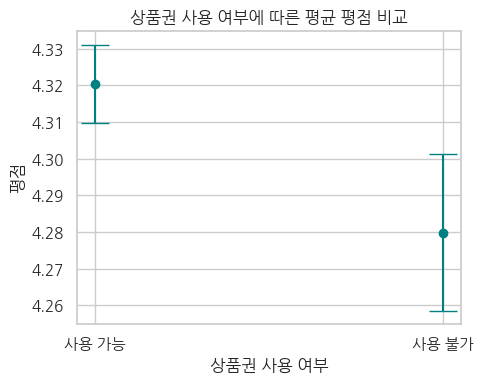

In [242]:
# 상품권 사용 여부를 숫자형으로 변환
df_plot['상품권_사용여부'] = df_plot['사용가능상품권'].apply(lambda x: 1 if x == '온누리상품권' else 0)
df_plot['상품권_사용여부_라벨'] = df_plot['상품권_사용여부'].map({1: '사용 가능', 0: '사용 불가'})

# 한글 폰트 등록
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

# 상품권 여부에 따른 시각화
def plot_mean_ci_v2(col, title):
    group_mean = df_plot.groupby(col)['rating'].mean()
    group_sem = df_plot.groupby(col)['rating'].sem()

    plt.figure(figsize=(5, 4))
    plt.errorbar(
        x=group_mean.index,
        y=group_mean.values,
        yerr=group_sem.values,
        fmt='o', capsize=10, color='teal'
    )
    plt.title(f"{title}에 따른 평균 평점 비교", fontproperties=font_prop)
    plt.xlabel(title, fontproperties=font_prop)
    plt.ylabel("평점", fontproperties=font_prop)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 실행
plot_mean_ci_v2('상품권_사용여부_라벨', '상품권 사용 여부')

In [247]:
# 리뷰 컬럼까지 포함해서 병합
df_merged = pd.merge(
    df_info,
    df_review[['mID', 'rate', 'review']],
    left_on='시장ID',
    right_on='mID',
    how='inner'
)

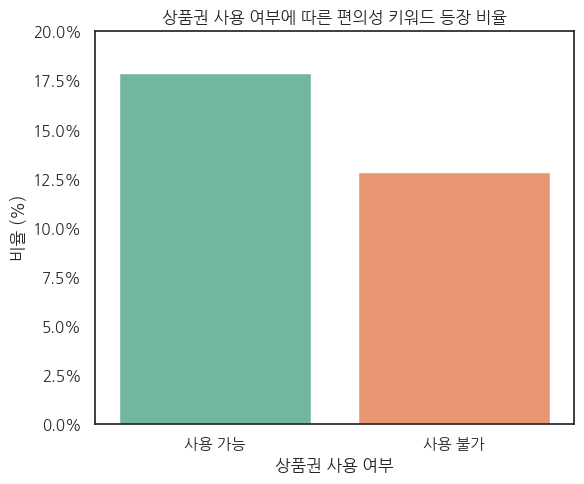

In [281]:
import matplotlib.ticker as mtick

# 편의성 관련 키워드
keywords = [
    '편리', '편해', '편하게', '간편', '간단', '쉬워', '쉽게', '빠르게', '수월',
    '결제', '현금', '카드', 'QR', '상품권', '이용', '접근', '주차',
    '가깝', '근처', '찾기 쉬움', '접근성', '환승', '교통'
]

def has_convenience_word(text):
    if pd.isna(text): return False
    return any(keyword in text for keyword in keywords)

# 2. 편의성 키워드 포함 여부 파악
df_merged['편의성_키워드'] = df_merged['review'].apply(has_convenience_word)

# 3. 상품권 여부 처리 (NaN은 '사용 불가'로 간주)
df_merged['상품권_사용'] = df_merged['사용가능상품권'].apply(lambda x: '사용 가능' if x == '온누리상품권' else '사용 불가')

# 4. 집계
result = df_merged.groupby('상품권_사용')['편의성_키워드'].mean().reset_index()

# 5. 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.barplot(
    data=result,
    x='상품권_사용',
    y='편의성_키워드',
    order=['사용 가능', '사용 불가'],  # 시각화 순서 고정
    palette='Set2'
)

plt.title('상품권 사용 여부에 따른 편의성 키워드 등장 비율')
plt.ylabel('비율 (%)')
plt.xlabel('상품권 사용 여부')
plt.ylim(0, 0.2)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))  # 소수 → 퍼센트
# plt.grid(axis='y', linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()

- 확장된 키워드에는 '결제', '카드', 'QR', '접근성', '주차', '가깝' 등
→ 실제 이용자의 ‘편의성’ 체감과 직결되는 표현들이 포함됨

- 상품권 사용 가능 시장에서 이 키워드들의 등장 비율이 높다는 건:

- 상품권 사용 가능성 자체가 리뷰에서 편의성과 함께 언급되는 경향이 있음
→ 즉, 사용자들은 상품권 사용을 편리함의 일부로 인식하고 있다는 증거가 될 수 있습니다.

> - 리뷰 내 편의성 관련 키워드 분석 결과, 상품권 사용 가능 시장에서 해당 키워드의 등장 비율이 더 높게 나타났다.
이는 상품권 사용이 시장 이용의 편의성과 연결되어 소비자 경험에 긍정적인 영향을 줄 수 있음을 시사한다.


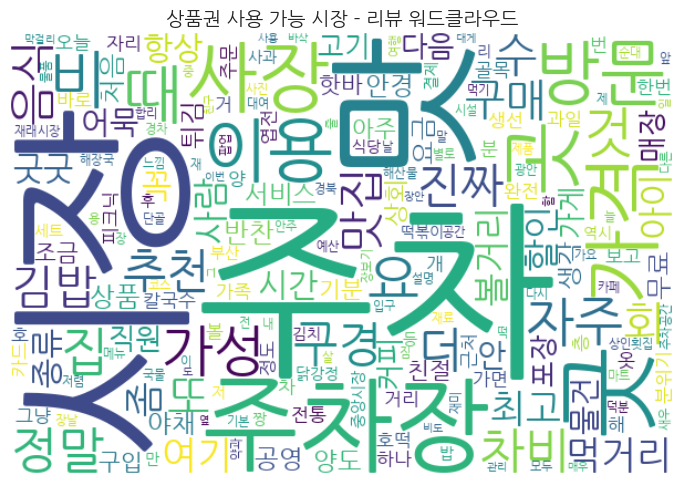

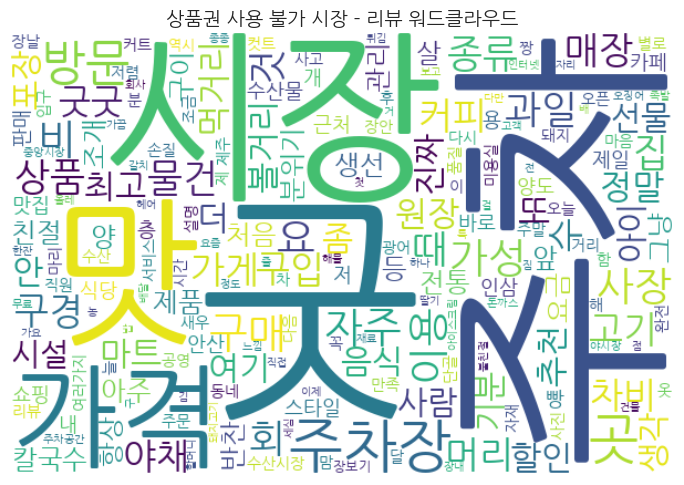

In [283]:
from wordcloud import WordCloud
from konlpy.tag import Okt
import matplotlib.pyplot as plt

# 형태소 분석기 준비
okt = Okt()

# 텍스트 정리 함수
def get_nouns(texts):
    all_nouns = []
    for text in texts.dropna():
        nouns = okt.nouns(text)
        all_nouns += nouns
    return all_nouns

# 상품권 사용 여부 분류
df_merged['상품권_사용'] = df_merged['사용가능상품권'].apply(lambda x: '사용 가능' if x == '온누리상품권' else '사용 불가')

# 각 그룹별 리뷰 모음
reviews_yes = df_merged[df_merged['상품권_사용'] == '사용 가능']['review']
reviews_no  = df_merged[df_merged['상품권_사용'] == '사용 불가']['review']

# 단어 추출
nouns_yes = get_nouns(reviews_yes)
nouns_no  = get_nouns(reviews_no)

# 빈도수 계산
from collections import Counter
freq_yes = Counter(nouns_yes)
freq_no  = Counter(nouns_no)

# 워드클라우드 생성 함수
def draw_wordcloud(freq, title):
    wc = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # 경로는 시스템에 따라 조정
                   background_color='white',
                   width=600, height=400).generate_from_frequencies(freq)

    plt.figure(figsize=(7, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# 시각화 실행
draw_wordcloud(freq_yes, '상품권 사용 가능 시장 - 리뷰 워드클라우드')
draw_wordcloud(freq_no,  '상품권 사용 불가 시장 - 리뷰 워드클라우드')

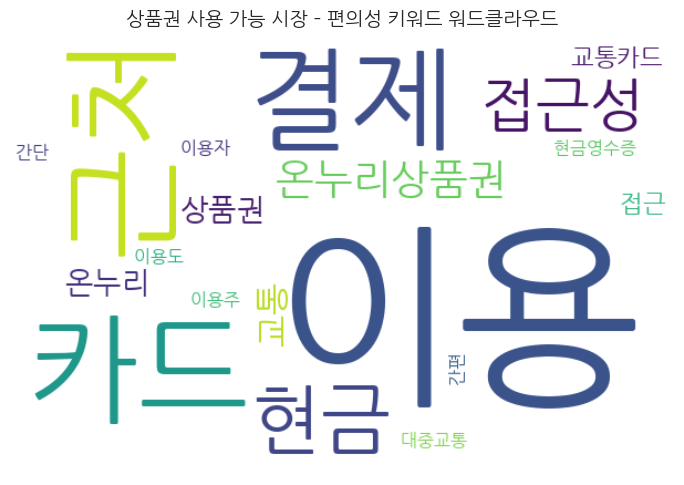

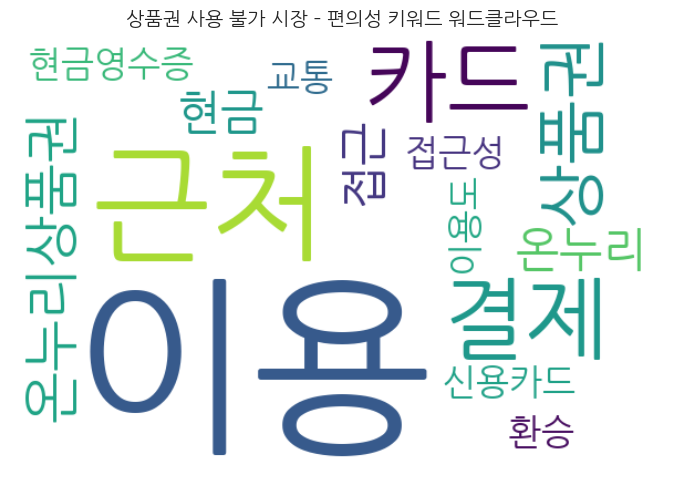

In [287]:
from wordcloud import WordCloud
from konlpy.tag import Okt
import matplotlib.pyplot as plt
from collections import Counter

# 편의성 키워드 사전
keywords = [
    # '편리', '편해', '편하게', '온누리', '간편', '간단', '쉬워', '쉽게', '빠르게', '수월',
    '온누리', '상품권', '간편', '간단', '쉬워', '쉽게', '빠르게', '수월',
    '결제', '현금', '카드', 'QR', '이용', '접근',
    '가깝', '근처', '찾기 쉬움', '접근성', '환승', '교통'
]

# 형태소 분석기
okt = Okt()

# 편의성 키워드만 추출
def extract_convenience_nouns(texts):
    filtered = []
    for text in texts.dropna():
        nouns = okt.nouns(text)
        for n in nouns:
            if any(k in n for k in keywords):
                filtered.append(n)
    return filtered

# 그룹별 리뷰 텍스트
reviews_yes = df_merged[df_merged['상품권_사용'] == '사용 가능']['review']
reviews_no  = df_merged[df_merged['상품권_사용'] == '사용 불가']['review']

# 키워드 필터링 후 단어 수 카운팅
freq_yes = Counter(extract_convenience_nouns(reviews_yes))
freq_no  = Counter(extract_convenience_nouns(reviews_no))

# 워드클라우드 함수
def draw_wordcloud(freq, title):
    wc = WordCloud(
        font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
        background_color='white',
        width=600, height=400
    ).generate_from_frequencies(freq)

    plt.figure(figsize=(7, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# 시각화
draw_wordcloud(freq_yes, '상품권 사용 가능 시장 – 편의성 키워드 워드클라우드')
draw_wordcloud(freq_no,  '상품권 사용 불가 시장 – 편의성 키워드 워드클라우드')